# Predict Nighttime Light Intensities from Daytime Light 

First pass.  
Current Goal: Use CNN to extract features from daytime lights (Landsat) data and predict levels of nighhtime light intensities (VIIRS).
***
General Steps:
1. Import the data
2. Feature creation
3. Build the Neural Net
4. Evaluate the Neural Net

In [3]:
import os
import pandas as pd
import geopandas as gpd
import rasterio

import getpass

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# Set directory
os.chdir("/Users/nguyenluong/wb_internship/Data/satellite_raw")

In [4]:
# Rob's code
if getpass.getuser() == 'robmarty':
    project_file_path = '/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites'
    
filepath_night = project_file_path + "/Data/VIIRS/RawData/VIIRS Annual/pak_viirs_median_2012.tif"
data_night = rasterio.open(filepath_night)
array_night = data_night.read()
np.nanmean(array_night)

array_night_flat = array_night.flatten()
array_night_flat_nona = array_night_flat[ ~np.isnan(array_night_flat) ]
plt.hist(array_night_flat_nona)

# 1. Import and Prep Data

## 1a. Load and Prep Nighttime Lights Data 

In [4]:
# Load nighttime VIIRS data (geojson)
viirs_gdf = gpd.read_file('VIIRS/VIIRS Annual/viirs_annual_polygon.geojson')
viirs_gdf.head(2)

,median_rad_2012,median_rad_2013,median_rad_2014,median_rad_2015,median_rad_2016,median_rad_2017,median_rad_2018,id,tile_id,geometry
0,0.121902,0.217595,0.179258,0.213304,0.148595,0.352908,0.34,1,42.0,"POLYGON ((74.66347 37.06224, 74.67021 37.06224..."
1,0.204110,0.223363,0.207353,0.283295,0.156230,0.375000,0.36,2,42.0,"POLYGON ((74.67021 37.06224, 74.67695 37.06224..."


Transform nighttime lights to lessen heavily skewed distribution. For now, **limit to only 2014 data**.   
***
Options tried here:
- natural log
- square root
- box-cox
- yeo-johnson

doc: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html#r742a88cfa144-1

In [5]:
from sklearn.preprocessing import power_transform

# Do log(x + 1) to have fully defined domain since data has x = 0
viirs_gdf['log_median_rad_2014'] = np.log(viirs_gdf['median_rad_2014'] + 1)
log_rad = np.log(viirs_gdf['median_rad_2014'] + 1).to_numpy()

sqrt_rad = np.sqrt(viirs_gdf['median_rad_2014']).to_numpy()

# do box-cox with (x + 1) because needs strictly positive values 
bc_rad = power_transform((viirs_gdf['median_rad_2014'] + 1).to_numpy().reshape(-1, 1), method='box-cox')

yj_rad = power_transform((viirs_gdf['median_rad_2014']).to_numpy().reshape(-1, 1), method='yeo-johnson')

Explore the distributions of variable transformations to decide which to go forward with.

Summary of log
DescribeResult(nobs=1814237, minmax=(0.0, 7.003241113635235), mean=0.20576721970884848, variance=0.062333206493509284, skewness=6.602233458742071, kurtosis=63.58599491384153)

Summary of square-root
DescribeResult(nobs=1814237, minmax=(0.0, 33.154083267445166), mean=0.45985096480354326, variance=0.10546258282824325, skewness=10.262868875497135, kurtosis=252.55956265564947)

Summary of box-cox
DescribeResult(nobs=1814237, minmax=(-3.0815043715438386, 2.3062005044008833), mean=8.316728796961411e-16, variance=1.0000005511962058, skewness=0.5906939197104081, kurtosis=-0.34560818439899155)

Summary of yeo-johnson
DescribeResult(nobs=1814237, minmax=(-3.0815044025438088, 2.3062004841188073), mean=4.371421043369711e-16, variance=1.0000005511962067, skewness=0.5906939018912442, kurtosis=-0.34560820768947886)



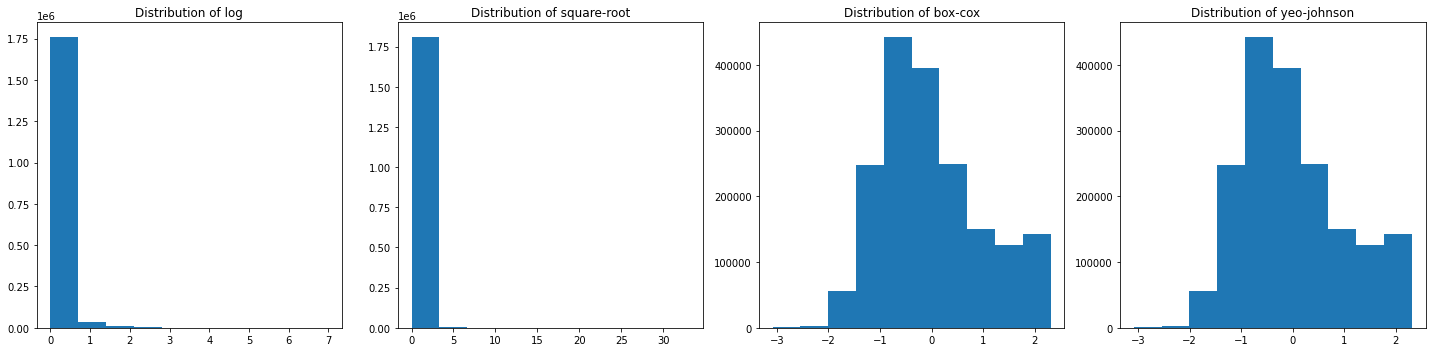

In [6]:
from scipy import stats

def explore_distrib(vars_dict):
    fig, ax = plt.subplots(figsize=(20,5), ncols=len(vars_dict.values()))
    i = 0
    for var_name, array in vars_dict.items():
        if len(array.shape) > 1:
            array = array.flatten()
        print('Summary of ' + var_name)
        print(stats.describe(array))
        print()
        ax[i].hist(array);
        ax[i].set_title('Distribution of ' + var_name);
        i += 1
    plt.tight_layout()
    plt.show()

vars_dict = {'log': log_rad, 'square-root': sqrt_rad, 
             'box-cox': bc_rad, 'yeo-johnson': yj_rad}
explore_distrib(vars_dict)

I feel like it makes sense to feel values positive for interpretation of radiance. Log has lowered skewness and smaller range of values. So, I will discretize log median radiance for 2014 with k-means clustering.

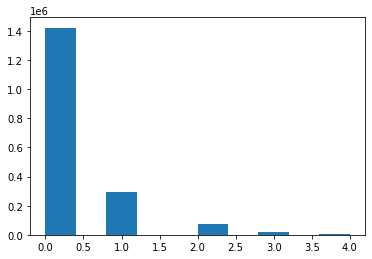

In [8]:
from sklearn.preprocessing import KBinsDiscretizer
# Reshape array to be a column rather than a row
log_rad = viirs_gdf['log_median_rad_2014'].to_numpy().reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
viirs_gdf['log_binned'] = discretizer.fit_transform(log_rad)
plt.hist(viirs_gdf['log_binned']);

In [12]:
# Now nighttime lights is bucketed into 5 categories
print('Bins')
print(viirs_gdf['log_binned'].value_counts())
print('Bin edges: {}'.format(discretizer.bin_edges_[0]))

Bins
0.0    1422278
1.0     294299
2.0      72758
3.0      18364
4.0       6538
Name: log_binned, dtype: int64
Bin edges: [0.         0.2270032  0.51066626 1.08064124 2.13831268 7.00324111]


## 1b. Create Random Sample and Map NTL to DTL 
***
For now, sample for 1000 observations for each NTL bin.

In [107]:
def sample_by_NTL(df, NTL_col, n):
    '''
    Create a dataframe that contains n samples from each NTL bin.
    '''
    rv = pd.DataFrame()
    for x in df[NTL_col].unique():
        bin_df = df[df[NTL_col] == x]
        sample_df = bin_df.sample(n=n)
        rv = rv.append(sample_df)
    return rv
        
df_2014 = viirs_gdf[['tile_id', 'median_rad_2014', 'log_median_rad_2014', 'log_binned', 'geometry']]
NTL_df = sample_by_NTL(df_2014, 'log_binned', 1000)
print(df['log_binned'].value_counts())
NTL_df.head(10)

4.0    1000
3.0    1000
2.0    1000
1.0    1000
0.0    1000
Name: log_binned, dtype: int64


,tile_id,median_rad_2014,log_median_rad_2014,log_binned,geometry
1750703,2.0,0.132470,0.124401,0.0,"POLYGON ((67.83179 24.88109, 67.83852 24.88109..."
882104,21.0,0.123471,0.116423,0.0,"POLYGON ((67.33322 29.61072, 67.33996 29.61072..."
1066753,18.0,0.102568,0.097642,0.0,"POLYGON ((62.46211 28.85613, 62.46884 28.85613..."
1061808,18.0,0.108502,0.103010,0.0,"POLYGON ((62.06460 28.87634, 62.07134 28.87634..."
1330579,12.0,0.083352,0.080060,0.0,"POLYGON ((64.98188 27.55582, 64.98862 27.55582..."
754976,28.0,0.227023,0.204591,0.0,"POLYGON ((71.42280 30.37204, 71.42954 30.37204..."
1040558,18.0,0.097452,0.092991,0.0,"POLYGON ((63.45250 28.96393, 63.45924 28.96393..."
1580469,9.0,0.129366,0.121656,0.0,"POLYGON ((68.04065 25.97928, 68.04738 25.97928..."
52003,40.0,0.203007,0.184824,0.0,"POLYGON ((72.18412 36.28745, 72.19086 36.28745..."
884722,21.0,0.166855,0.154312,0.0,"POLYGON ((67.48818 29.59724, 67.49492 29.59724..."


## 1c. Get DLT corresponding sampled NTL - incomplete

### Scatchwork

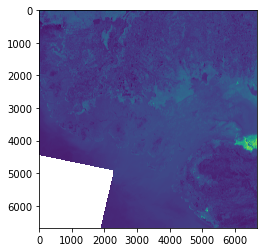

In [288]:
# Load sample polygon
sample_poly = None
for row in NTL_df[0:1].iterrows():
    sample_poly = row[1]['geometry']

# Load sample DLT
sample_DTL = rasterio.open('Landsat/New_2014/l8_2014_tile2_b1.tif')
plt.imshow(data.read(1))

In [289]:
# Format coords correctly for rasterio to mask
coords = format_coords(sample_poly)
# Crop
out_img, out_transform = mask(sample_DTL, shapes=coords, crop=True)
print(out_img.shape)

(1, 25, 26)


In [298]:
from rasterio.mask import mask

def format_coords(Polygon):
    '''
    Format coordinates of a Polygon to what rasterio likes for masking / cropping.
    '''
    coords = list(Polygon.exterior.coords)
    dictionary = {'type': 'Polygon'}
    dictionary['coordinates'] = [[list(tup) for tup in coords]]
    return [dictionary]

def crop(raw_DTL, polygon):
    '''
    Crops DLT according to VIIRS polygon.
    '''
    shapes = format_coords(polygon)
    out_img, out_transform = mask(raw_DTL, shapes=shapes, crop=True)
    return out_img
    
def get_DTL(row, directory):
    '''
    For a given VIIRS observation, grab and crop corresponding DLT data.
    '''
    all_bands = []
    bands = [*range(1,8)]
    for b in bands:
        tile = row['tile_id']
        polygon = row['geometry']
        filename = ''.join(['l8_2014_tile', str(int(tile)), '_b', str(b), '.tif'])
        filepath = os.path.join(directory, filename)
        raw_DTL = rasterio.open(filepath)
        cropped_DTL = crop(raw_DTL, polygon)
        all_bands.append(cropped_DTL)
    return all_bands

def create_arrays(NTL_df, source='Landsat', year='New_2014'):
    '''
    Gets DTL images, crops them, create arrays representing DLT and NLT to become features and targets respectively.
    INCOMPLETE FUNCTION.
    
    Returns: DLT, NLT (numpy.arrays)
    '''
    df = NTL_df.copy()
    directory = os.path.join(source, year)
    for index, row in df.iterrows():
        DTL = get_DLT(row, directory)
        print(DTL) 

In [299]:
NLT_tiny = NTL_df[0:2]
# For now, they just prints the cropped bands
create_arrays(NLT_tiny)

[array([[[ 894.5,  907.5,  994. ,  994. , 1002.5,  962.5,  963. ,  968.5,
         1008.5, 1006.5,  859.5,  811. , 1029. , 1029. , 1139. , 1178.5,
         1102.5,  992.5,  959.5,  994. , 1016. , 1047. , 1024. ,  958. ,
          958. ,    0. ],
        [ 952.5,  937. , 1000.5, 1000.5, 1024.5,  989.5,  965.5,  951. ,
          947.5,  958. ,  880.5,  801.5, 1097.5, 1097.5, 1222. , 1184.5,
         1009. ,  966.5, 1002.5, 1010.5, 1022.5, 1037.5,  963. ,  897. ,
          897. ,    0. ],
        [1057.5,  966.5,  966.5,  906. ,  996. ,  994. ,  979. ,  951. ,
          944. ,  915. ,  924.5,  862. ,  975. ,  975. , 1158.5, 1102. ,
         1049.5,  958.5,  990. , 1022.5, 1027.5, 1038. ,  954. ,  886.5,
          886.5,    0. ],
        [1051. ,  955.5,  955.5,  822. ,  889. ,  944. ,  966.5,  981. ,
          986.5,  932. ,  933. ,  828. ,  772.5,  772.5, 1007. , 1062. ,
         1030. ,  969. ,  995.5, 1041.5, 1061. , 1059. ,  987. ,  933. ,
          933. ,    0. ],
        [1059. ,  9

[array([[[1234. , 1217.5, 1139.5, 1247. , 1194. , 1216.5, 1253. , 1253. ,
         1310. , 1239.5, 1166. , 1099. , 1045.5, 1111. , 1335.5, 1335.5,
         1373.5, 1391. , 1401.5, 1503. , 1465.5, 1429. , 1429. , 1404.5,
         1340. ,    0. ],
        [1237.5, 1175.5, 1203. , 1259.5, 1234.5, 1246.5, 1234.5, 1234.5,
         1288. , 1264.5, 1222.5, 1071. , 1060.5, 1124. , 1332. , 1332. ,
         1401. , 1411.5, 1391.5, 1513. , 1540.5, 1584. , 1584. , 1432.5,
         1373.5,    0. ],
        [1173.5, 1202. , 1281. , 1259.5, 1150.5, 1142.5, 1190. , 1190. ,
         1241. , 1318. , 1183. , 1073.5, 1033. , 1175.5, 1314. , 1314. ,
         1405. , 1424. , 1414. , 1546. , 1582.5, 1522.5, 1522.5, 1406.5,
         1389.5,    0. ],
        [1157. , 1168. , 1187. , 1178.5, 1159. , 1137.5, 1180.5, 1180.5,
         1291.5, 1329. , 1141.5, 1074.5, 1022.5, 1197. , 1197. , 1325. ,
         1400.5, 1444. , 1398.5, 1547.5, 1515. , 1398.5, 1398.5, 1312.5,
         1409.5,    0. ],
        [1283. , 12

# Feature Creation
Reshape the data into an array of 3D tensors and normalize each element.
***  
*What satellite data ultimately needs to look like*
- data_train, data_test: (np.array) array containing 3D arrays each representing one Landsat image
- target_train, target_test: (np.array with elements in range(0,5)) 1D array of nighttime light intensities split into 5 buckets

In [68]:
#Sample data
from keras.datasets import mnist
(trainX, trainY), (testX, testY) = mnist.load_data()

In [69]:
#Look at array shapes
print('training data shape: {}'.format(trainX.shape))
print('training target shape: {}'.format(trainY.shape))
print('testing data shape: {}'.format(testX.shape))
print('testing target shape: {}'.format(testY.shape))

training data shape: (60000, 28, 28)
training target shape: (60000,)
testing data shape: (10000, 28, 28)
testing target shape: (10000,)


target value: 5


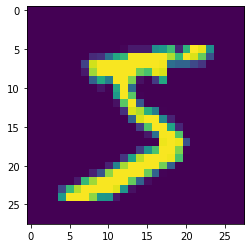

In [8]:
#Sample image and target
plt.imshow(trainX[0], origin='upper', interpolation='nearest');
print('target value: {}'.format(trainY[0]))

In [9]:
def prep_dataset(X, Y, height, width, channels):
    # Reshape dataset to have include a single channel
    X = X.reshape((X.shape[0], height, width, channels))
    # One-hot encode targets
    Y = to_categorical(Y)
    return X, Y

def normalize(X):
    # Convert from ints to floats and normalize to 0-1
    return X.astype('float32') / 255.0

# Build the CNN

In [10]:
def define_model(height, width, channels, num_classes):
    # Define layers
    model = Sequential()
    model.add(Conv2D(filters=64, 
                     kernel_size=(5, 5), 
                     activation='relu', 
                     input_shape=(height, width, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    print('Model has been defined. Model summary below.')
    model.summary()
    
    return model

# Evaluate the CNN

In [11]:
def evaluate_model(model, trainX, trainY, testX, testY):
    # Fit model
    history = model.fit(trainX, trainY, 
                        epochs=2, batch_size=1000, 
                        validation_data=(testX, testY), verbose=0)
    print('Model has been fit.')
    
    # Evaluate model
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    print('Model has been evaluted.')
    print('Accuracy: {:.4f}'.format(accuracy))


def evaluate_with_crossval(model, dataX, dataY, k=2):
    # Define k-fold cross-val
    kfold = KFold(k, shuffle=True, random_state=1)
    print('Entering cross validation.')
    
    # Loop through folds
    for train_idx, test_idx in kfold.split(dataX):
        # Select subsets for training and testing
        trainX, trainY, testX, testY = dataX[train_idx], dataY[train_idx], dataX[test_idx], dataY[test_idx]
        print('Subsets have been selected.')
        # Pass to evaluate_model
        evaluate_model(model, trainX, trainY, testX, testY)

In [12]:
def go():
    # Load dataset
    (raw_trainX, raw_trainY), (raw_testX, raw_testY) = mnist.load_data()
    
    # Define image characteristics
    height = raw_trainX[0].shape[0]
    width = raw_trainX[0].shape[1]
    channels = 1
    num_classes = 10 #digits 0-9
    
    # Prep both training and testing data
    trainX, trainY = prep_dataset(raw_trainX, raw_trainY, height, width, channels)
    testX, testY = prep_dataset(raw_testX, raw_testY, height, width, channels)
    
    # Prep pixel data
    trainX, testX = normalize(trainX), normalize(testX)

    # Define and evaluate model
    model = define_model(height, width, channels, num_classes)
    evaluate_model(model, trainX, trainY, testX, testY)
    #evaluate_with_crossval(model, trainX, trainY)

In [13]:
go()

Model has been defined. Model summary below.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               921700    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 924,374
Trainable params: 924,374
Non-trainable params: 0
_________________________________________________________________
Model has been fit.
Model has been evaluted.
Accuracy: 0.9714
